# **Intent Based Sentiment (2 classes) SST-2 Dataset**

### Step 1: Install & Import Dependencies

In [2]:
!pip install -q transformers==4.41.2 peft==0.11.1 accelerate==0.31.0 datasets


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 75.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 77.3 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    confusion_matrix, ConfusionMatrixDisplay,
    classification_report, roc_auc_score, roc_curve, auc,
    brier_score_loss
)
from sklearn.calibration import calibration_curve
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity

import torch
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    Trainer, TrainingArguments, EarlyStoppingCallback, AutoConfig
)
from peft import LoraConfig, TaskType, get_peft_model

### Step 2: Mount Google Drive & Load Data

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

file_path = "/content/drive/MyDrive/SST-2 (2 Classes).csv"
df = pd.read_csv(file_path, encoding='ISO-8859-1')
df = df[['Text', 'Sentiment']].dropna()
df.head()

Mounted at /content/drive


,Text,Sentiment
0,"A stirring, funny and finally transporting re-...",1
1,Apparently reassembled from the cutting-room f...,0
2,They presume their audience won't sit still fo...,0
3,This is a visually stunning rumination on love...,1
4,Jonathan Parker's Bartleby should have been th...,1


In [5]:
total_instances = len(df)
print(f"Total instances: {total_instances}")

sentiment_counts = df['Sentiment'].value_counts()
print("Number of instances per sentiment:")
print(sentiment_counts)

Total instances: 9613
Number of instances per sentiment:
Sentiment
1    4963
0    4650
Name: count, dtype: int64


### Step 3: Visualize Dataset Distribution

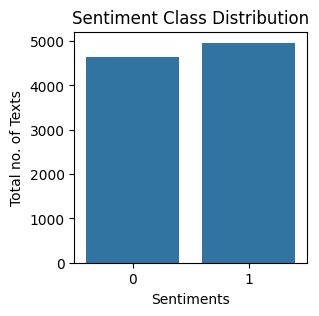

In [6]:
plt.figure(figsize=(3,3))
sns.countplot(data=df, x='Sentiment')
plt.title("Sentiment Class Distribution")
plt.xlabel("Sentiments")
plt.ylabel("Total no. of Texts")
plt.grid(False)
plt.show()


### Step 4: Encode Labels

In [7]:
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['Sentiment'])

print("Label Mapping:")
for i, label in enumerate(label_encoder.classes_):
    print(f"{label}: {i}")


Label Mapping:
0: 0
1: 1


### Step 5: Train-Test Split

In [8]:
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df['Text'].tolist(),
    df['label'].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=df['label']
)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts,
    temp_labels,
    test_size=0.5,
    random_state=42,
    stratify=temp_labels
)

print(f"Train size: {len(train_texts)}, Val size: {len(val_texts)}, Test size: {len(test_texts)}")

Train size: 7690, Val size: 961, Test size: 962


### Step 6: Tokenization

In [9]:
base_model_name_1 = "distilbert-base-uncased"
finetuned_model_name_1 = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer_1 = AutoTokenizer.from_pretrained(base_model_name_1)

train_encodings_1 = tokenizer_1(train_texts, truncation=True, padding=True, max_length=512)
val_encodings_1   = tokenizer_1(val_texts, truncation=True, padding=True, max_length=512)
test_encodings_1  = tokenizer_1(test_texts, truncation=True, padding=True, max_length=512)

base_model_name_2 = "textattack/roberta-base-SST-2"
finetuned_model_name_2 = "roberta-base"
tokenizer_2 = AutoTokenizer.from_pretrained(base_model_name_2)

train_encodings_2 = tokenizer_2(train_texts, truncation=True, padding=True, max_length=512)
val_encodings_2   = tokenizer_2(val_texts, truncation=True, padding=True, max_length=512)
test_encodings_2  = tokenizer_2(test_texts, truncation=True, padding=True, max_length=512)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/525 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

### Step 7: Dataset Class

In [10]:
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()} | {'labels': torch.tensor(self.labels[idx])}

    def __len__(self):
        return len(self.labels)

train_dataset_1 = SentimentDataset(train_encodings_1, train_labels)
val_dataset_1   = SentimentDataset(val_encodings_1, val_labels)
test_dataset_1  = SentimentDataset(test_encodings_1, test_labels)

train_dataset_2 = SentimentDataset(train_encodings_2, train_labels)
val_dataset_2   = SentimentDataset(val_encodings_2, val_labels)
test_dataset_2  = SentimentDataset(test_encodings_2, test_labels)

### Step 8: Define Metrics Function

In [12]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    proba = torch.softmax(torch.tensor(logits), dim=-1).numpy()

    acc = accuracy_score(labels, preds) * 100

    prec, rec, f1, _ = precision_recall_fscore_support(labels, preds, average="binary")

    sims = []
    for i in range(len(labels)):
        true_onehot = np.zeros(proba.shape[1])
        true_onehot[labels[i]] = 1
        sims.append(cosine_similarity([true_onehot], [proba[i]])[0][0])
    similarity_score = np.mean(sims) * 100

    confidence_score = np.mean(np.max(proba, axis=1)) * 100

    return {
        "eval_Accuracy": acc,
        "eval_Precision": prec * 100,
        "eval_Recall": rec * 100,
        "eval_F1 Score": f1 * 100,
        "eval_Similarity Score": similarity_score,
        "eval_Confidence Score": confidence_score
    }

### Step 9: Evaluate Without Fine-Tuning

In [14]:
baseline_model_1 = AutoModelForSequenceClassification.from_pretrained(finetuned_model_name_1)

baseline_trainer_1 = Trainer(
    model=baseline_model_1,
    args=TrainingArguments(
        output_dir="./results_1",
        per_device_eval_batch_size=32,
        report_to="none"
    ),
    eval_dataset=test_dataset_1,
    compute_metrics=compute_metrics
)

baseline_metrics_1 = baseline_trainer_1.evaluate()

print("\n===== Performance of DistilBERT Model =====\n")

metrics_to_show = [
    "Accuracy",
    "Precision",
    "Recall",
    "F1 Score",
    "Similarity Score",
    "Confidence Score"
]

for metric in metrics_to_show:
    key = f"eval_{metric}"
    if key in baseline_metrics_1:
        print(f"{metric} is: {baseline_metrics_1[key]:.2f}%")

print("\n===== Evaluation Details =====")
print(f"Eval Loss: {baseline_metrics_1.get('eval_loss', 0.0):.4f}")
print(f"Runtime: {baseline_metrics_1.get('eval_runtime', 0.0)} sec")
print(f"Samples per second: {baseline_metrics_1.get('eval_samples_per_second', 0.0)}")

baseline_model_2 = AutoModelForSequenceClassification.from_pretrained(base_model_name_2)

baseline_trainer_2 = Trainer(
    model=baseline_model_2,
    args=TrainingArguments(
        output_dir="./results_2",
        per_device_eval_batch_size=32,
        report_to="none"
    ),
    eval_dataset=test_dataset_2,
    compute_metrics=compute_metrics
)

baseline_metrics_2 = baseline_trainer_2.evaluate()

print("\n===== Performance of RoBERTa Model =====\n")

for metric in metrics_to_show:
    key = f"eval_{metric}"
    if key in baseline_metrics_2:
        print(f"{metric} is: {baseline_metrics_2[key]:.2f}%")

print("\n===== Evaluation Details =====")
print(f"Eval Loss: {baseline_metrics_2.get('eval_loss', 0.0):.4f}")
print(f"Runtime: {baseline_metrics_2.get('eval_runtime', 0.0)} sec")
print(f"Samples per second: {baseline_metrics_2.get('eval_samples_per_second', 0.0)}")


===== Performance of DistilBERT Model =====

Accuracy is: 98.13%
Precision is: 97.61%
Recall is: 98.79%
F1 Score is: 98.20%
Similarity Score is: 98.27%
Confidence Score is: 99.56%

===== Evaluation Details =====
Eval Loss: 0.0755
Runtime: 2.1035 sec
Samples per second: 457.328


model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at textattack/roberta-base-SST-2 were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



===== Performance of RoBERTa Model =====

Accuracy is: 97.51%
Precision is: 97.21%
Recall is: 97.99%
F1 Score is: 97.60%
Similarity Score is: 98.04%
Confidence Score is: 97.31%

===== Evaluation Details =====
Eval Loss: 0.0657
Runtime: 3.3154 sec
Samples per second: 290.162


### Step 9.1: Confusion Matrix (Without Fine-Tuning)

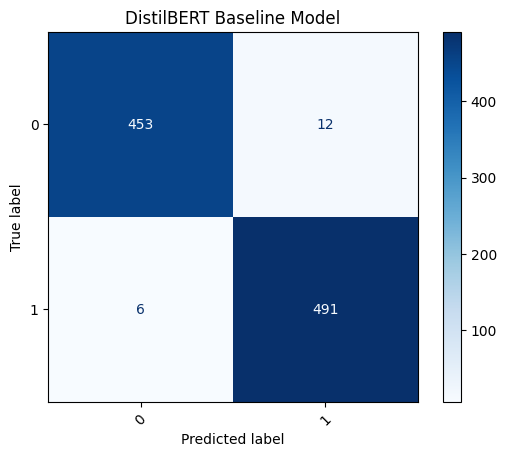

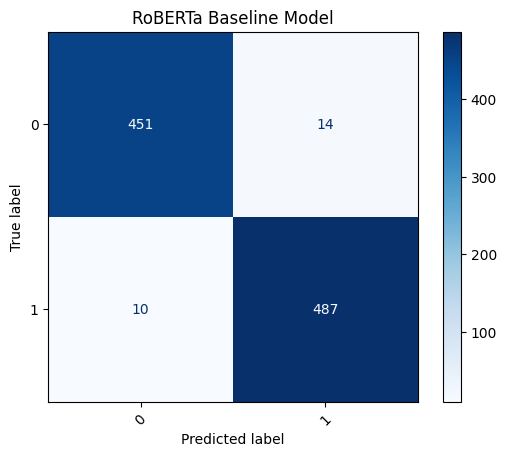

In [18]:
preds_1 = baseline_trainer_1.predict(test_dataset_1)
y_true_1 = preds_1.label_ids
y_pred_1 = preds_1.predictions.argmax(-1)

cm_1 = confusion_matrix(y_true_1, y_pred_1)

class_names = label_encoder.classes_

ConfusionMatrixDisplay(confusion_matrix=cm_1, display_labels=class_names).plot(cmap="Blues", xticks_rotation=45)
plt.title("DistilBERT Baseline Model")
plt.show()

preds_2 = baseline_trainer_2.predict(test_dataset_2)
y_true_2 = preds_2.label_ids
y_pred_2 = preds_2.predictions.argmax(-1)

cm_2 = confusion_matrix(y_true_2, y_pred_2)

ConfusionMatrixDisplay(confusion_matrix=cm_2, display_labels=class_names).plot(cmap="Blues", xticks_rotation=45)
plt.title("RoBERTa Baseline Model")
plt.show()

### Step 10: Base Model Fine-Tuning Configuration & Training

In [19]:
config_1 = AutoConfig.from_pretrained(
    base_model_name_1,
    num_labels=len(label_encoder.classes_),
    hidden_dropout_prob=0.4,
    attention_probs_dropout_prob=0.3,
    classifier_dropout=0.3
)

model_base_1 = AutoModelForSequenceClassification.from_pretrained(
    base_model_name_1,
    config=config_1
)

training_args_1 = TrainingArguments(
    output_dir="./results_1",
    num_train_epochs=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    weight_decay=0.2,
    warmup_ratio=0.1,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    logging_strategy="epoch",
    report_to="none",
    fp16=True,
    gradient_accumulation_steps=1,
    save_total_limit=2,
    max_grad_norm=1.0,
    lr_scheduler_type="linear",
    seed=42,
    dataloader_pin_memory=False,
)

trainer_base_1 = Trainer(
    model=model_base_1,
    args=training_args_1,
    train_dataset=train_dataset_1,
    eval_dataset=val_dataset_1,
    compute_metrics=compute_metrics,
    callbacks=[
        EarlyStoppingCallback(early_stopping_patience=3),
    ]
)

trainer_base_1.train()

config_2 = AutoConfig.from_pretrained(
    base_model_name_2,
    num_labels=len(label_encoder.classes_),
    hidden_dropout_prob=0.4,
    attention_probs_dropout_prob=0.3,
    classifier_dropout=0.3
)

model_base_2 = AutoModelForSequenceClassification.from_pretrained(
    base_model_name_2,
    config=config_2
)

training_args_2 = TrainingArguments(
    output_dir="./results_2",
    num_train_epochs=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-5,
    weight_decay=0.2,
    warmup_ratio=0.1,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    logging_strategy="epoch",
    report_to="none",
    fp16=True,
    gradient_accumulation_steps=1,
    save_total_limit=2,
    max_grad_norm=1.0,
    lr_scheduler_type="linear",
    seed=42,
    dataloader_pin_memory=False,
)

trainer_base_2 = Trainer(
    model=model_base_2,
    args=training_args_2,
    train_dataset=train_dataset_2,
    eval_dataset=val_dataset_2,
    compute_metrics=compute_metrics,
    callbacks=[
        EarlyStoppingCallback(early_stopping_patience=3),
    ]
)

trainer_base_2.train()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/accelerate/accelerator.py:477: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 score,Similarity score,Confidence score
0,0.468200,0.339997,86.992716,84.543762,91.532258,87.899322,88.863132,92.537979
2,0.189100,0.440167,89.490114,90.388548,89.112903,89.746193,90.237254,98.208527
4,0.058800,0.628847,89.073881,88.712871,90.322581,89.510490,89.507981,99.230675
6,0.032000,0.682002,90.426639,92.083333,89.112903,90.573770,90.396585,99.436584


/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at textattack/roberta-base-SST-2 were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 score,Similarity score,Confidence score
0,0.584900,0.127184,95.213319,92.452830,98.790323,95.516569,95.970415,97.238197
2,0.453500,0.206685,93.236212,89.541284,98.387097,93.756004,93.873575,96.826294
4,0.401500,0.234139,92.403746,88.665448,97.782258,93.000959,93.517825,97.583603
6,0.367100,0.288162,92.299688,88.086643,98.387097,92.952381,93.103187,98.178963


TrainOutput(global_step=5769, training_loss=0.4551584895427067, metrics={'train_runtime': 1102.72, 'train_samples_per_second': 69.737, 'train_steps_per_second': 8.715, 'total_flos': 1470071355170400.0, 'train_loss': 0.4551584895427067, 'epoch': 6.0})

#### Step 10.1: Fine-Tuned Base Model Evaluation & Performance Analysis

In [20]:
finetuned_metrics_1 = trainer_base_1.evaluate(test_dataset_1)

print("\n===== Performance after Fine-Tuning DistilBERT Model =====\n")

metrics_to_show = [
    "Accuracy",
    "Precision",
    "Recall",
    "F1 Score",
    "Similarity Score",
    "Confidence Score"
]

for metric in metrics_to_show:
    key = f"eval_{metric}"
    if key in finetuned_metrics_1:
        print(f"{metric} is: {finetuned_metrics_1[key]:.2f}%")

print("\n===== Evaluation Details =====")
print(f"Eval Loss: {finetuned_metrics_1.get('eval_loss', 0.0):.4f}")
print(f"Runtime: {finetuned_metrics_1.get('eval_runtime', 0.0)} sec")
print(f"Samples per second: {finetuned_metrics_1.get('eval_samples_per_second', 0.0)}")

finetuned_metrics_2 = trainer_base_2.evaluate(test_dataset_2)

print("\n===== Performance after Fine-Tuning RoBERTa Model =====\n")

for metric in metrics_to_show:
    key = f"eval_{metric}"
    if key in finetuned_metrics_2:
        print(f"{metric} is: {finetuned_metrics_2[key]:.2f}%")

print("\n===== Evaluation Details =====")
print(f"Eval Loss: {finetuned_metrics_2.get('eval_loss', 0.0):.4f}")
print(f"Runtime: {finetuned_metrics_2.get('eval_runtime', 0.0)} sec")
print(f"Samples per second: {finetuned_metrics_2.get('eval_samples_per_second', 0.0)}")


===== Performance after Fine-Tuning DistilBERT Model =====

Accuracy is: 87.73%
Precision is: 86.10%
Recall is: 90.95%
F1 Score is: 88.45%
Similarity Score is: 89.65%
Confidence Score is: 92.06%

===== Evaluation Details =====
Eval Loss: 0.3161
Runtime: 2.2883 sec
Samples per second: 420.392



===== Performance after Fine-Tuning RoBERTa Model =====

Accuracy is: 97.82%
Precision is: 96.12%
Recall is: 99.80%
F1 Score is: 97.93%
Similarity Score is: 98.11%
Confidence Score is: 97.82%

===== Evaluation Details =====
Eval Loss: 0.0650
Runtime: 4.7721 sec
Samples per second: 201.588


#### Step 10.2: Confusion Matrix Analysis

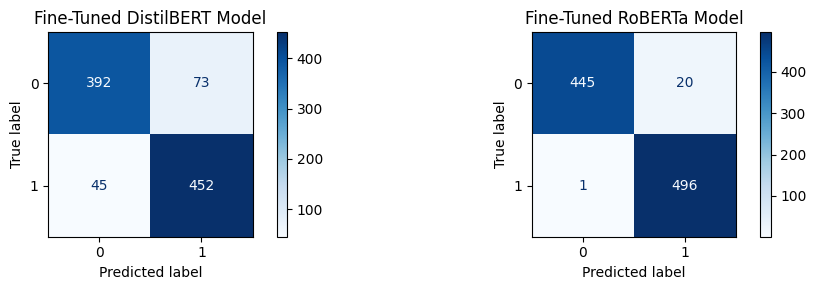

In [21]:
preds_1 = trainer_base_1.predict(test_dataset_1)
y_true_1 = preds_1.label_ids
y_pred_1 = preds_1.predictions.argmax(-1)

preds_2 = trainer_base_2.predict(test_dataset_2)
y_true_2 = preds_2.label_ids
y_pred_2 = preds_2.predictions.argmax(-1)

cm_1 = confusion_matrix(y_true_1, y_pred_1)
cm_2 = confusion_matrix(y_true_2, y_pred_2)

class_names = label_encoder.classes_

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))

ConfusionMatrixDisplay(confusion_matrix=cm_1, display_labels=class_names).plot(cmap="Blues", ax=ax1)
ax1.set_title("Fine-Tuned DistilBERT Model")

ConfusionMatrixDisplay(confusion_matrix=cm_2, display_labels=class_names).plot(cmap="Blues", ax=ax2)
ax2.set_title("Fine-Tuned RoBERTa Model")

plt.tight_layout()
plt.show()

#### Step 10.3: Training Progress Visualization & Loss Analysis

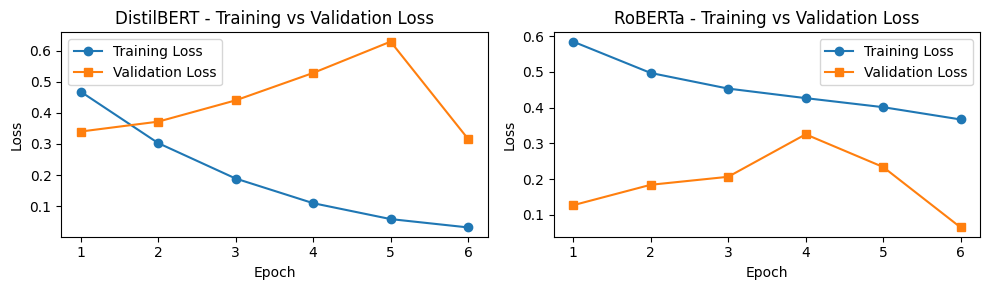

In [22]:
logs_base_1 = trainer_base_1.state.log_history
logs_base_2 = trainer_base_2.state.log_history

train_loss_base_1 = {}
eval_loss_base_1 = {}
train_loss_base_2 = {}
eval_loss_base_2 = {}

for log in logs_base_1:
    if "loss" in log and "epoch" in log:
        train_loss_base_1[float(log["epoch"])] = log["loss"]
    if "eval_loss" in log and "epoch" in log:
        eval_loss_base_1[float(log["epoch"])] = log["eval_loss"]

for log in logs_base_2:
    if "loss" in log and "epoch" in log:
        train_loss_base_2[float(log["epoch"])] = log["loss"]
    if "eval_loss" in log and "epoch" in log:
        eval_loss_base_2[float(log["epoch"])] = log["eval_loss"]

epochs_base_1 = sorted(set(train_loss_base_1.keys()) | set(eval_loss_base_1.keys()))
epochs_base_2 = sorted(set(train_loss_base_2.keys()) | set(eval_loss_base_2.keys()))
train_vals_base_1 = [train_loss_base_1.get(e, None) for e in epochs_base_1]
eval_vals_base_1 = [eval_loss_base_1.get(e, None) for e in epochs_base_1]
train_vals_base_2 = [train_loss_base_2.get(e, None) for e in epochs_base_2]
eval_vals_base_2 = [eval_loss_base_2.get(e, None) for e in epochs_base_2]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))

ax1.plot(epochs_base_1, train_vals_base_1, label="Training Loss", marker="o")
ax1.plot(epochs_base_1, eval_vals_base_1, label="Validation Loss", marker="s")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.set_title("DistilBERT - Training vs Validation Loss")
ax1.legend()
ax1.grid(False)

ax2.plot(epochs_base_2, train_vals_base_2, label="Training Loss", marker="o")
ax2.plot(epochs_base_2, eval_vals_base_2, label="Validation Loss", marker="s")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Loss")
ax2.set_title("RoBERTa - Training vs Validation Loss")
ax2.legend()
ax2.grid(False)

plt.tight_layout()
plt.show()

### Step 11: Adapter (LoRA) Model Configuration & Training

In [23]:
adapter_model_1 = AutoModelForSequenceClassification.from_pretrained(
    base_model_name_1,
    num_labels=len(label_encoder.classes_)
)

peft_config_1 = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=8,
    lora_alpha=16,
    lora_dropout=0.3,
    target_modules=["q_lin", "k_lin", "v_lin", "out_lin"],
    bias="none",
    modules_to_save=["classifier", "pre_classifier"]
)

adapter_model_1 = get_peft_model(adapter_model_1, peft_config_1)

adapter_model_1.print_trainable_parameters()

adapter_args_1 = TrainingArguments(
    output_dir="./results-adapter-1",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-4,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=8,
    num_train_epochs=15,
    weight_decay=0.1,
    warmup_ratio=0.15,
    logging_dir="./logs-adapter-1",
    logging_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none",
    seed=42,
    fp16=True,
    gradient_accumulation_steps=2,
    max_grad_norm=1.0,
    save_total_limit=2,
    lr_scheduler_type="cosine",
    dataloader_pin_memory=False,
    remove_unused_columns=True
)

trainer_adapter_1 = Trainer(
    model=adapter_model_1,
    args=adapter_args_1,
    train_dataset=train_dataset_1,
    eval_dataset=val_dataset_1,
    compute_metrics=compute_metrics,
    callbacks=[
        EarlyStoppingCallback(early_stopping_patience=5),
    ]
)

print("Training DistilBERT with LoRA...")
trainer_adapter_1.train()

adapter_metrics_1 = trainer_adapter_1.evaluate(test_dataset_1)
print("DistilBERT Performance with LoRA:", adapter_metrics_1)

adapter_model_2 = AutoModelForSequenceClassification.from_pretrained(
    base_model_name_2,
    num_labels=len(label_encoder.classes_)
)

peft_config_2 = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=8,
    lora_alpha=16,
    lora_dropout=0.3,
    target_modules=["query", "key", "value", "output.dense"],
    bias="none",
    modules_to_save=["classifier"]
)

adapter_model_2 = get_peft_model(adapter_model_2, peft_config_2)

adapter_model_2.print_trainable_parameters()

adapter_args_2 = TrainingArguments(
    output_dir="./results-adapter-2",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-4,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=8,
    num_train_epochs=15,
    weight_decay=0.1,
    warmup_ratio=0.15,
    logging_dir="./logs-adapter-2",
    logging_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none",
    seed=42,
    fp16=True,
    gradient_accumulation_steps=2,
    max_grad_norm=1.0,
    save_total_limit=2,
    lr_scheduler_type="cosine",
    dataloader_pin_memory=False,
    remove_unused_columns=True
)

trainer_adapter_2 = Trainer(
    model=adapter_model_2,
    args=adapter_args_2,
    train_dataset=train_dataset_2,
    eval_dataset=val_dataset_2,
    compute_metrics=compute_metrics,
    callbacks=[
        EarlyStoppingCallback(early_stopping_patience=5),
    ]
)

print("Training RoBERTa with LoRA...")
trainer_adapter_2.train()

adapter_metrics_2 = trainer_adapter_2.evaluate(test_dataset_2)
print("RoBERTa Performance with LoRA:", adapter_metrics_2)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/accelerate/accelerator.py:477: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


trainable params: 887,042 || all params: 67,842,052 || trainable%: 1.3075
Training DistilBERT with LoRA...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 score,Similarity score,Confidence score
0,0.424000,0.350980,85.952133,82.877960,91.733871,87.081340,88.345380,91.323143
2,0.279300,0.367298,86.888658,84.644195,91.129032,87.766990,88.982256,95.089035
4,0.193100,0.466187,88.865765,91.648822,86.290323,88.888889,89.812765,97.445442
6,0.130100,0.469666,88.761707,89.917695,88.104839,89.002037,89.765476,97.774254


/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in ver

DistilBERT Performance with LoRA: {'eval_Accuracy': 89.29313929313929, 'eval_Precision': 90.3688524590164, 'eval_Recall': 88.73239436619718, 'eval_F1 Score': 89.54314720812184, 'eval_Similarity Score': 90.7824823733856, 'eval_Confidence Score': 91.48174285888672, 'eval_loss': 0.28677821159362793, 'eval_runtime': 2.3116, 'eval_samples_per_second': 416.17, 'eval_steps_per_second': 52.346, 'epoch': 6.999479979199168}


Some weights of the model checkpoint at textattack/roberta-base-SST-2 were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.12/dist-packages/accelerate/accelerator.py:477: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


trainable params: 1,550,594 || all params: 126,197,764 || trainable%: 1.2287
Training RoBERTa with LoRA...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 score,Similarity score,Confidence score
0,0.116700,0.136007,95.941727,94.891945,97.379032,96.119403,96.599880,98.135933
2,0.135300,0.246183,95.421436,95.934959,95.161290,95.546559,95.549540,99.695107
4,0.092000,0.277619,95.629553,94.685039,96.975806,95.816733,95.695329,99.800545
6,0.082600,0.326928,94.276795,92.649903,96.572581,94.570582,94.469462,99.549141


/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in ver

RoBERTa Performance with LoRA: {'eval_Accuracy': 97.92099792099792, 'eval_Precision': 97.0414201183432, 'eval_Recall': 98.99396378269618, 'eval_F1 Score': 98.00796812749005, 'eval_Similarity Score': 98.21893517736916, 'eval_Confidence Score': 98.69784545898438, 'eval_loss': 0.07147061824798584, 'eval_runtime': 3.7443, 'eval_samples_per_second': 256.927, 'eval_steps_per_second': 32.316, 'epoch': 6.0}


#### Step 11.1: Adapter (LoRA) Model Evaluation & Performance Analysis

In [24]:
adapter_metrics_1 = trainer_adapter_1.evaluate(test_dataset_1)

print("\n===== DistilBERT Performance with Adapter (LoRA) =====\n")

metrics_to_show = [
    "Accuracy",
    "Precision",
    "Recall",
    "F1 Score",
    "Similarity Score",
    "Confidence Score"
]

for metric in metrics_to_show:
    key = f"eval_{metric}"
    if key in adapter_metrics_1:
        print(f"{metric} is: {adapter_metrics_1[key]:.2f}%")

print("\n===== Evaluation Details =====")
print(f"Eval Loss: {adapter_metrics_1.get('eval_loss', 0.0):.4f}")
print(f"Runtime: {adapter_metrics_1.get('eval_runtime', 0.0)} sec")
print(f"Samples per second: {adapter_metrics_1.get('eval_samples_per_second', 0.0)}")

adapter_metrics_2 = trainer_adapter_2.evaluate(test_dataset_2)

print("\n===== RoBERTa Performance with Adapter (LoRA) =====\n")

for metric in metrics_to_show:
    key = f"eval_{metric}"
    if key in adapter_metrics_2:
        print(f"{metric} is: {adapter_metrics_2[key]:.2f}%")

print("\n===== Evaluation Details =====")
print(f"Eval Loss: {adapter_metrics_2.get('eval_loss', 0.0):.4f}")
print(f"Runtime: {adapter_metrics_2.get('eval_runtime', 0.0)} sec")
print(f"Samples per second: {adapter_metrics_2.get('eval_samples_per_second', 0.0)}")


===== DistilBERT Performance with Adapter (LoRA) =====

Accuracy is: 89.29%
Precision is: 90.37%
Recall is: 88.73%
F1 Score is: 89.54%
Similarity Score is: 90.78%
Confidence Score is: 91.48%

===== Evaluation Details =====
Eval Loss: 0.2868
Runtime: 4.8266 sec
Samples per second: 199.31



===== RoBERTa Performance with Adapter (LoRA) =====

Accuracy is: 97.92%
Precision is: 97.04%
Recall is: 98.99%
F1 Score is: 98.01%
Similarity Score is: 98.22%
Confidence Score is: 98.70%

===== Evaluation Details =====
Eval Loss: 0.0715
Runtime: 10.5746 sec
Samples per second: 90.973


#### Step 11.2: Confusion Matrix Analysis

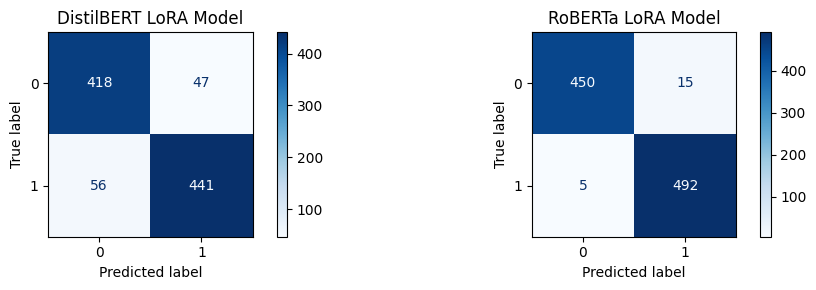

In [25]:
preds_1 = trainer_adapter_1.predict(test_dataset_1)
y_true_1, y_pred_1 = preds_1.label_ids, preds_1.predictions.argmax(-1)
cm_1 = confusion_matrix(y_true_1, y_pred_1)

preds_2 = trainer_adapter_2.predict(test_dataset_2)
y_true_2, y_pred_2 = preds_2.label_ids, preds_2.predictions.argmax(-1)
cm_2 = confusion_matrix(y_true_2, y_pred_2)

class_names = label_encoder.classes_

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))

ConfusionMatrixDisplay(confusion_matrix=cm_1, display_labels=class_names).plot(cmap="Blues", ax=ax1)
ax1.set_title("DistilBERT LoRA Model")

ConfusionMatrixDisplay(confusion_matrix=cm_2, display_labels=class_names).plot(cmap="Blues", ax=ax2)
ax2.set_title("RoBERTa LoRA Model")

plt.tight_layout()
plt.show()

#### Step 11.3: Training Progress Visualization & Loss Analysis

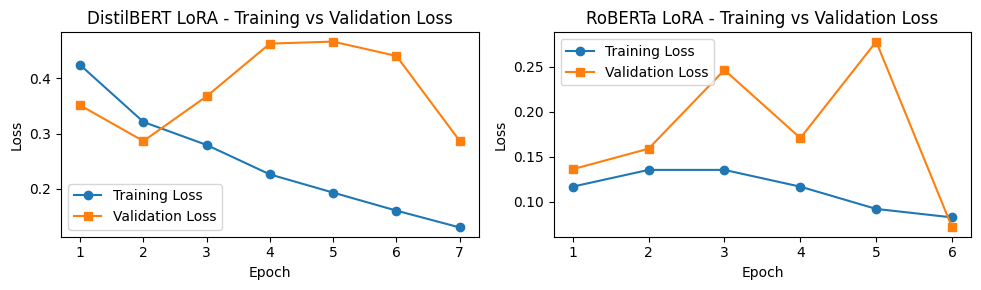

In [26]:
logs_adapter_1 = trainer_adapter_1.state.log_history
logs_adapter_2 = trainer_adapter_2.state.log_history

train_loss_adapter_1 = {}
eval_loss_adapter_1 = {}
train_loss_adapter_2 = {}
eval_loss_adapter_2 = {}

for log in logs_adapter_1:
    if "loss" in log and "epoch" in log:
        train_loss_adapter_1[float(log["epoch"])] = log["loss"]
    if "eval_loss" in log and "epoch" in log:
        eval_loss_adapter_1[float(log["epoch"])] = log["eval_loss"]

for log in logs_adapter_2:
    if "loss" in log and "epoch" in log:
        train_loss_adapter_2[float(log["epoch"])] = log["loss"]
    if "eval_loss" in log and "epoch" in log:
        eval_loss_adapter_2[float(log["epoch"])] = log["eval_loss"]

epochs_adapter_1 = sorted(set(train_loss_adapter_1.keys()) | set(eval_loss_adapter_1.keys()))
epochs_adapter_2 = sorted(set(train_loss_adapter_2.keys()) | set(eval_loss_adapter_2.keys()))
train_vals_adapter_1 = [train_loss_adapter_1.get(e, None) for e in epochs_adapter_1]
eval_vals_adapter_1 = [eval_loss_adapter_1.get(e, None) for e in epochs_adapter_1]
train_vals_adapter_2 = [train_loss_adapter_2.get(e, None) for e in epochs_adapter_2]
eval_vals_adapter_2 = [eval_loss_adapter_2.get(e, None) for e in epochs_adapter_2]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))

ax1.plot(epochs_adapter_1, train_vals_adapter_1, label="Training Loss", marker="o")
ax1.plot(epochs_adapter_1, eval_vals_adapter_1, label="Validation Loss", marker="s")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.set_title("DistilBERT LoRA - Training vs Validation Loss")
ax1.legend()
ax1.grid(False)

ax2.plot(epochs_adapter_2, train_vals_adapter_2, label="Training Loss", marker="o")
ax2.plot(epochs_adapter_2, eval_vals_adapter_2, label="Validation Loss", marker="s")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Loss")
ax2.set_title("RoBERTa LoRA - Training vs Validation Loss")
ax2.legend()
ax2.grid(False)

plt.tight_layout()
plt.show()

### Step 12: Comprehensive Model Comparison & Performance Visualization

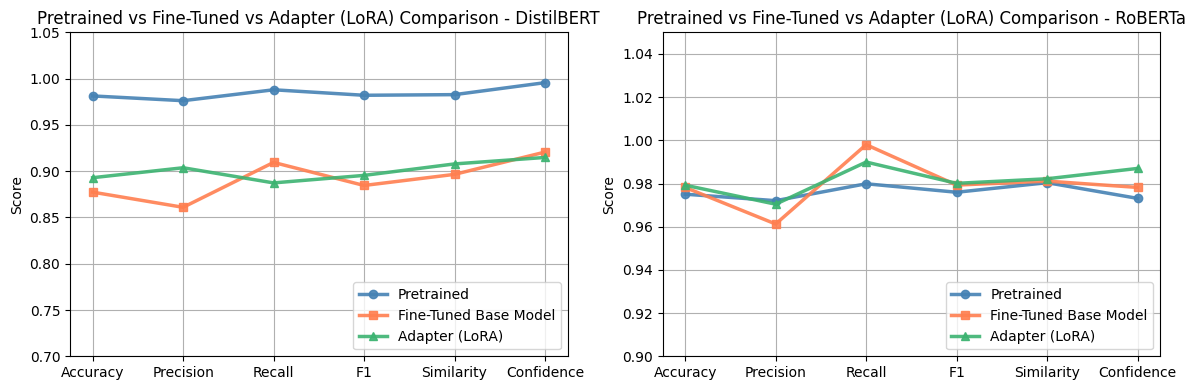

In [43]:
metrics = ["Accuracy", "Precision", "Recall", "F1", "Similarity", "Confidence"]

pretrained_vals_1 = np.array([baseline_metrics_1[f"eval_{m}"] for m in ["Accuracy", "Precision", "Recall", "F1 Score", "Similarity Score", "Confidence Score"]]) / 100
base_vals_1 = np.array([finetuned_metrics_1[f"eval_{m}"] for m in ["Accuracy", "Precision", "Recall", "F1 Score", "Similarity Score", "Confidence Score"]]) / 100
adapter_vals_1 = np.array([adapter_metrics_1[f"eval_{m}"] for m in ["Accuracy", "Precision", "Recall", "F1 Score", "Similarity Score", "Confidence Score"]]) / 100

pretrained_vals_2 = np.array([baseline_metrics_2[f"eval_{m}"] for m in ["Accuracy", "Precision", "Recall", "F1 Score", "Similarity Score", "Confidence Score"]]) / 100
base_vals_2 = np.array([finetuned_metrics_2[f"eval_{m}"] for m in ["Accuracy", "Precision", "Recall", "F1 Score", "Similarity Score", "Confidence Score"]]) / 100
adapter_vals_2 = np.array([adapter_metrics_2[f"eval_{m}"] for m in ["Accuracy", "Precision", "Recall", "F1 Score", "Similarity Score", "Confidence Score"]]) / 100

x = np.arange(len(metrics))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(x, pretrained_vals_1, marker='o', linestyle='-', linewidth=2.5, alpha=0.9, label="Pretrained", color='steelblue')
ax1.plot(x, base_vals_1, marker='s', linestyle='-', linewidth=2.5, alpha=0.9, label="Fine-Tuned Base Model", color='coral')
ax1.plot(x, adapter_vals_1, marker='^', linestyle='-', linewidth=2.5, alpha=0.9, label="Adapter (LoRA)", color='mediumseagreen')
ax1.set_xticks(x)
ax1.set_xticklabels(metrics, fontsize=10)
ax1.set_ylabel("Score")
ax1.set_ylim(0.70, 1.05)
ax1.set_title("Pretrained vs Fine-Tuned vs Adapter (LoRA) Comparison - DistilBERT")
ax1.grid(True)
ax1.legend(loc="lower right")

ax2.plot(x, pretrained_vals_2, marker='o', linestyle='-', linewidth=2.5, alpha=0.9, label="Pretrained", color='steelblue')
ax2.plot(x, base_vals_2, marker='s', linestyle='-', linewidth=2.5, alpha=0.9, label="Fine-Tuned Base Model", color='coral')
ax2.plot(x, adapter_vals_2, marker='^', linestyle='-', linewidth=2.5, alpha=0.9, label="Adapter (LoRA)", color='mediumseagreen')
ax2.set_xticks(x)
ax2.set_xticklabels(metrics, fontsize=10)
ax2.set_ylabel("Score")
ax2.set_ylim(0.90, 1.05)
ax2.set_title("Pretrained vs Fine-Tuned vs Adapter (LoRA) Comparison - RoBERTa")
ax2.grid(True)
ax2.legend(loc="lower right")

plt.tight_layout()
plt.show()